In [119]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from src.optimizers import *
np.random.seed(0)


#### Data pre-processing for MONK Datasets 

In [182]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

# df = pd.read_csv("../ML_project/data/Monk_1/monks-1.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
df = pd.read_csv("/Users/Mostafa/Desktop/first_year_Pisa/ML/project_implementation/data/monk2/monks-2.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
df.set_index("index", inplace=True)
y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
for i in range(1, X.shape[1]):
    X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / np.std(X.iloc[:, i])
X.head()

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_21352\1792702156.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_4     -1.233337
data_7     -1.233337
data_9     -1.233337
data_10    -1.233337
data_11    -1.233337
              ...   
data_421    1.293135
data_422    1.293135
data_425    1.293135
data_427    1.293135
data_432    1.293135
Name: 2, Length: 169, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / np.std(X.iloc[:, i])
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_21352\1792702156.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_4     -1.017912
data_7     -1.017912
data_9     -1.017912
data_10    -1.017912
data_11    -1.017912
              ...   
data_421    0.982403
data_422    0.982403
data_425 

In [175]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
test_data.set_index("index", inplace=True)
# test_data.head()
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
for i in range(1, X_test.shape[1]):
    X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

#### Data pre-processing for CUP DATASET 

In [184]:
##############################################################################
####     TODO: Implement the preprocessing part for the CUP dataset      #####
##############################################################################

# df = ...



In [177]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (135, 6)
Validation Features Shape: (34, 6)
Training Target Shape: (135,)
Validation Target Shape: (34,)


In [178]:
def create_batches(X, y, batch_size):
    """Create mini-batches from the data"""
    # Convert to numpy array if input is pandas DataFrame/Series
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        
        yield X[batch_indices], y[batch_indices]

In [185]:
import matplotlib.pyplot as plt

def plot_accuracies(train_accuracies, val_accuracies, title="Accuracy Over Epochs"):
    """
    Plot training and validation accuracies over epochs.

    Parameters:
    - train_accuracies (list or array): Accuracy values for training data over epochs.
    - val_accuracies (list or array): Accuracy values for validation data over epochs.
    - title (str): Title of the plot. Default is "Accuracy Over Epochs".
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies, label="Train Accuracy", color="blue", linewidth=2)
    plt.plot(val_accuracies, label="Validation Accuracy", linestyle="--", color="orange", linewidth=2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [179]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons,  l1=0.0, l2=0.0):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l1 = l1
        self.l2 = l2
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
   
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues) 
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # L1 regularization
        if self.l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.l1 * dl1
            
        # L2 regularization
        if self.l2 > 0:
            self.dweights += 2 * self.l2 * self.weights
            
        # Gradient on values 
        self.dinputs = np.dot(dvalues, self.weights.T)  
               
    def get_regularization_loss(self):
        """
        Calculate regularization loss for the layer.
        
        Returns:
        - regularization_loss: Combined L1 and L2 regularization loss
        """
        regularization_loss = 0
        
        if self.l1 > 0:
            regularization_loss += self.l1 * np.sum(np.abs(self.weights))
            
        if self.l2 > 0:
            regularization_loss += self.l2 * np.sum(self.weights * self.weights)
            
        return regularization_loss
    
class Dropout:
    def __init__(self, rate):
        """
        Initialize a dropout layer.
        
        Parameters:
        - rate: Dropout rate (fraction of inputs to drop)
        """
        self.rate = 1 - rate  # Store keep rate instead of drop rate
        self.mask = None
        
    def forward(self, inputs, training=True):
        """
        Perform the forward pass with dropout.
        
        Parameters:
        - inputs: Input data
        - training: Boolean indicating training mode
        """
        self.inputs = inputs
        
        if training:
            self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.mask
        else:
            self.output = inputs
            
    def backward(self, dvalues):
        """
        Perform the backward pass through dropout.
        
        Parameters:
        - dvalues: Gradient of the loss with respect to the output
        """
        self.dinputs = dvalues * self.mask
        
        
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # Since we need to modify the orginial variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

class Activation_Leaky_ReLU:
    def forward(self, inputs, alpha=0.01):
        self.inputs = inputs
        self.output = np.where(inputs > 0, inputs, alpha * inputs)

    def backward(self, dvalues, alpha=0.01):  # f′(x) = {1, α : if  x > 0 ; if x ≤ 0}
        self.dinputs = dvalues.copy()
        self.dinputs = np.where(self.inputs > 0, 1, alpha)
        self.dinputs *= dvalues

class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1/(1 + np.exp(-inputs))

    def backward(self, dvalues):  # f′(x) = σ(x)⋅(1−σ(x))
        self.dinputs = dvalues.copy()
        self.dinputs = self.output * (1 - self.output)
        self.dinputs *= dvalues


class Activation_Tanh:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):  # f′(x) = 1−tanh**2(x)
        self.dinputs = dvalues.copy()
        self.dinputs = 1 - (self.output)**2
        self.dinputs *= dvalues

class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            
            jacobian_matrix = np.diagflat(single_output) - \
                                np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
        
        
    def forward(self, y_pred, y_true):
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
        
# X, y = create_data(100, 3)
 
dense1 = Layer_Dense(6, 10)
# activation4 = Activation_ReLU()
activation4 = Activation_Leaky_ReLU()
# activation4 = Activation_Sigmoid()
# activation4 = Activation_Tanh()
dropout = Dropout(rate=0.3)
dense2 = Layer_Dense(10, 2)

loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()


optimizer = Optimizer_Adam(learning_rate=0.003)
# optimizer = Optimizer_Adagrad(learning_rate=0.3, decay=1e-3)
# optimizer = Optimizer_SGD(learning_rate=0.003, momentum=0.90)
# optimizer = Optimizer_RMSprop(learning_rate=0.003, decay=1e-3)

epoch: 0, train_acc: 0.919, train_loss: -0.201, val_acc: 0.765, val_loss: -0.415, learning_rate: 0.003
epoch: 100, train_acc: 0.925, train_loss: -0.192, val_acc: 0.765, val_loss: -0.402, learning_rate: 0.003
epoch: 200, train_acc: 0.925, train_loss: -0.215, val_acc: 0.735, val_loss: -0.394, learning_rate: 0.003
epoch: 300, train_acc: 0.896, train_loss: -0.221, val_acc: 0.765, val_loss: -0.390, learning_rate: 0.003
epoch: 400, train_acc: 0.919, train_loss: -0.189, val_acc: 0.706, val_loss: -0.432, learning_rate: 0.003
epoch: 500, train_acc: 0.906, train_loss: -0.203, val_acc: 0.765, val_loss: -0.417, learning_rate: 0.003
epoch: 600, train_acc: 0.931, train_loss: -0.194, val_acc: 0.735, val_loss: -0.405, learning_rate: 0.003
epoch: 700, train_acc: 0.938, train_loss: -0.191, val_acc: 0.706, val_loss: -0.418, learning_rate: 0.003
epoch: 800, train_acc: 0.915, train_loss: -0.221, val_acc: 0.706, val_loss: -0.407, learning_rate: 0.003
epoch: 900, train_acc: 0.925, train_loss: -0.196, val_acc

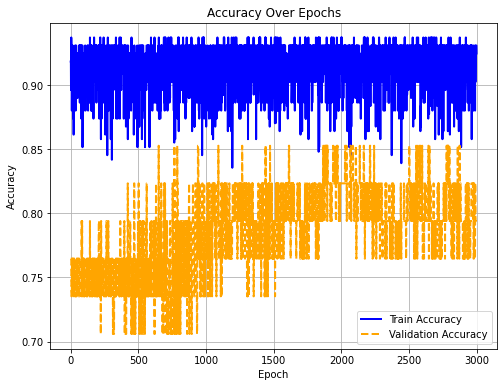

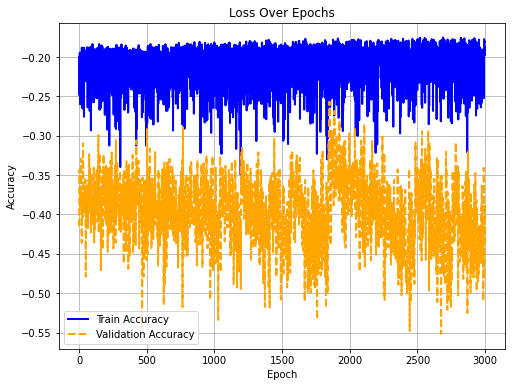

In [186]:
n_epochs = 3000
batch_size = 32


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []
    
    # Mini-batch training
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        dense1.forward(X_batch)
        activation4.forward(dense1.output)
        dense2.forward(activation4.output)
        loss = loss_activation.forward(dense2.output, y_batch)
        
        # Calculate accuracy for this batch
        predictions = np.argmax(loss_activation.output, axis=1)
        if len(y_batch.shape) == 2:
            y_true = np.argmax(y_batch, axis=1)
        else:
            y_true = y_batch
        accuracy = np.mean(predictions == y_true)
        
        # Backward pass
        loss_activation.backward(loss_activation.output, y_batch)
        dense2.backward(loss_activation.dinputs)
        activation4.backward(dense2.dinputs)
        dense1.backward(activation4.dinputs)
        
        # Update weights and biases
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()
        
        batch_losses.append(loss)
        batch_accuracies.append(accuracy)
    
    # Calculate epoch-level training metrics
    epoch_loss = np.mean(batch_losses)
    epoch_accuracy = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation pass (entire validation dataset)
    dense1.forward(X_val)
    activation4.forward(dense1.output)
    dense2.forward(activation4.output)
    val_loss = loss_activation.forward(dense2.output, y_val)
    
    # Calculate validation accuracy
    val_predictions = np.argmax(loss_activation.output, axis=1)
    if len(y_val.shape) == 2:
        y_val_true = np.argmax(y_val, axis=1)
    else:
        y_val_true = y_val
    val_accuracy = np.mean(val_predictions == y_val_true)
    
    # Append validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print progress
    if not epoch % 100:
        print(f"epoch: {epoch}, "
              f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
              f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
              f"learning_rate: {optimizer.current_learning_rate}")

plot_accuracies(train_accuracies, val_accuracies, title="Accuracy Over Epochs")
plot_accuracies(train_losses, val_losses, title="Loss Over Epochs")

In [187]:
test_accuracy = []
batch_size = 32

        # Forward pass
dense1.forward(X_test)
activation4.forward(dense1.output)
dense2.forward(activation4.output)
loss = loss_activation.forward(dense2.output, y_batch)

# Calculate accuracy for this batch
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_true = np.argmax(y_batch, axis=1)
else:
    y_true = y_test
accuracy = np.mean(predictions == y_true)
test_accuracy.append(accuracy)

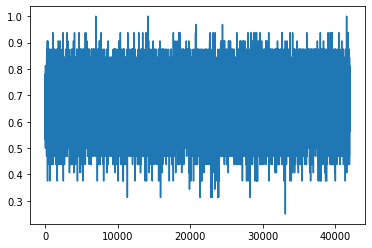

In [188]:
plt.plot(test_accuracy)

In [189]:
test_accuracy

[0.625,
 0.625,
 0.6875,
 0.71875,
 0.78125,
 0.65625,
 0.53125,
 0.65625,
 0.6875,
 0.6875,
 0.71875,
 0.625,
 0.75,
 0.625,
 0.59375,
 0.65625,
 0.71875,
 0.75,
 0.625,
 0.6875,
 0.65625,
 0.65625,
 0.65625,
 0.6875,
 0.78125,
 0.65625,
 0.65625,
 0.5625,
 0.5,
 0.75,
 0.6875,
 0.6875,
 0.59375,
 0.71875,
 0.6875,
 0.71875,
 0.59375,
 0.625,
 0.6875,
 0.65625,
 0.75,
 0.8125,
 0.65625,
 0.59375,
 0.6875,
 0.75,
 0.625,
 0.59375,
 0.625,
 0.65625,
 0.78125,
 0.71875,
 0.6875,
 0.59375,
 0.6875,
 0.8125,
 0.6875,
 0.75,
 0.78125,
 0.6875,
 0.5,
 0.71875,
 0.8125,
 0.78125,
 0.65625,
 0.625,
 0.59375,
 0.59375,
 0.5625,
 0.625,
 0.625,
 0.53125,
 0.65625,
 0.59375,
 0.71875,
 0.8125,
 0.59375,
 0.71875,
 0.6875,
 0.71875,
 0.71875,
 0.65625,
 0.6875,
 0.6875,
 0.59375,
 0.53125,
 0.65625,
 0.75,
 0.75,
 0.625,
 0.6875,
 0.6875,
 0.75,
 0.5625,
 0.8125,
 0.6875,
 0.6875,
 0.5625,
 0.65625,
 0.6875,
 0.8125,
 0.6875,
 0.6875,
 0.625,
 0.75,
 0.625,
 0.5,
 0.65625,
 0.65625,
 0.65625,
 0.7